## **Importing the libraries required**

In [1]:
# Importing the basic libraries we will require for the project

import numpy as np;
import pandas as pd;
import matplotlib.pyplot as plt;
import seaborn as sns;
import csv,json;
import os;

# Importing the Machine Learning models we require from Scikit-Learn
from sklearn import tree;
from sklearn.tree import DecisionTreeClassifier;
from sklearn.ensemble import RandomForestClassifier;

# Importing the other functions we may require from Scikit-Learn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV;
from sklearn.metrics import recall_score, roc_curve, classification_report, confusion_matrix;
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder;
from sklearn.compose import ColumnTransformer;
from sklearn.impute import SimpleImputer;
from sklearn.pipeline import Pipeline;
from sklearn import metrics, model_selection;

# Setting the random seed to 1 for reproducibility of results
import random;
random.seed(1);
np.random.seed(1);

# Code to ignore warnings from function usage
import warnings;
import numpy as np
warnings.filterwarnings('ignore')

In [2]:
df_astro = pd.read_csv('Skyserver250k.csv');
df_astro.head()

df_astro = df_astro.sample(n=50000)

# Checking for any missing values just in case
df_astro.isnull().sum()

# Let's also check for duplicate rows in the dataset
df_astro.duplicated().sum()

### Percentage class distribution of the target variable "class"
df_astro['class'].value_counts(1)*100

le = LabelEncoder()
df_astro["class"] = le.fit_transform(df_astro["class"])
df_astro["class"] = df_astro["class"].astype(int)

# We would like the format of the values in the table to be simple float numbers with 5 decimal places, hence the code below
pd.set_option('display.float_format', lambda x: '%.5f' % x)

# Let's view the statistical summary of the columns in the dataset
df_astro.describe().T

# Removing the objid and specobjid columns from the dataset
df_astro.drop(columns=['objid', 'specobjid'], inplace=True)

In [3]:
# Defining the hist_box() function
def hist_box(col):
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': (0.15, 0.85)}, figsize=(15,10))
    sns.set(style='darkgrid')
    # Adding a graph in each part
    sns.boxplot(df_astro[col], ax=ax_box, showmeans=True)
    sns.distplot(df_astro[col], ax=ax_hist)
    ax_hist.axvline(df_astro[col].mean(), color='green', linestyle='--') # Green line corresponds to the mean in the plot
    ax_hist.axvline(df_astro[col].median(), color='orange', linestyle='-') # Orange line corresponds to the median in the plot
    plt.show()

In [4]:
def plot(column):
    for i in range(3):
        sns.kdeplot(data=df_astro[df_astro["class"] == i][column], label = le.inverse_transform([i]))
    sns.kdeplot(data=df_astro[column],label = ["All"])
    plt.legend();

def log_plot(column):
    for i in range(3):
        sns.kdeplot(data=np.log(df_astro[df_astro["class"] == i][column]), label = le.inverse_transform([i]))
    sns.kdeplot(data=np.log(df_astro[column]),label = ["All"])
    plt.legend();

In [5]:
df_astro = df_astro.drop("rerun",axis=1)
df_astro = df_astro.drop("run",axis=1)
df_astro = df_astro.drop("field",axis=1)
df_astro = df_astro.drop("camcol",axis=1)

# **Modeling and evaluation**

## **Data Preparation**

In [6]:
# Separating the dependent and independent columns in the dataset
X = df_astro.drop(['class'], axis=1);
Y = df_astro[['class']];

In [7]:
# Splitting the dataset into the Training and Testing set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42, stratify=Y);

# Checking the shape of the Train and Test sets
print('X Train Shape:', X_train.shape);
print('X Test Shape:', X_test.shape);
print('Y Train Shape:', y_train.shape);
print('Y Test Shape:', y_test.shape);

X Train Shape: (45000, 11)
X Test Shape: (5000, 11)
Y Train Shape: (45000, 1)
Y Test Shape: (5000, 1)


## **Model Building**

In [8]:
def metrics_score(actual, predicted):
    print(classification_report(actual, predicted));
    cm = confusion_matrix(actual, predicted);
    plt.figure(figsize = (8,5));
    sns.heatmap(cm, annot = True, fmt = '.2f', xticklabels = ['Galaxy', 'Quasar', 'Star'], yticklabels = ['Galaxy', 'Quasar', 'Star'])
    plt.ylabel('Actual'); plt.xlabel('Predicted');
    plt.show()

### **The k-Nearest Neighbors Model**
#### **Before Scaling and PCA**

              precision    recall  f1-score   support

           0       0.79      0.96      0.87     22983
           1       0.62      0.27      0.38      4751
           2       0.90      0.78      0.84     17266

    accuracy                           0.82     45000
   macro avg       0.77      0.67      0.69     45000
weighted avg       0.81      0.82      0.80     45000



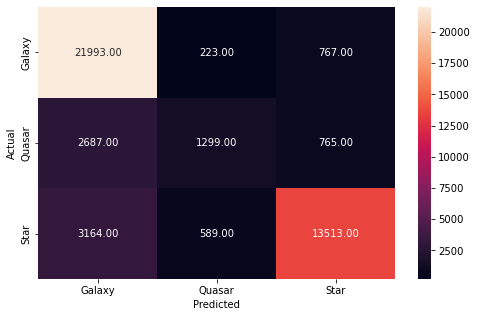

In [9]:
from sklearn.neighbors import KNeighborsClassifier
knn_model= KNeighborsClassifier()
knn_model.fit(X_train,y_train)
knn_train_predictions = knn_model.predict(X_train)
metrics_score(y_train,knn_train_predictions)

              precision    recall  f1-score   support

           0       0.77      0.93      0.84      2554
           1       0.39      0.16      0.23       528
           2       0.84      0.74      0.79      1918

    accuracy                           0.78      5000
   macro avg       0.67      0.61      0.62      5000
weighted avg       0.76      0.78      0.76      5000



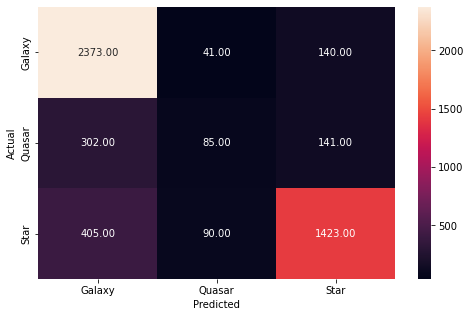

In [10]:
y_test_pred_knn = knn_model.predict(X_test);
metrics_score(y_test, y_test_pred_knn)

#### **After Scaling and PCA**

              precision    recall  f1-score   support

           0       0.93      0.97      0.95     22983
           1       0.99      0.91      0.95      4751
           2       0.95      0.92      0.94     17266

    accuracy                           0.94     45000
   macro avg       0.96      0.93      0.94     45000
weighted avg       0.94      0.94      0.94     45000



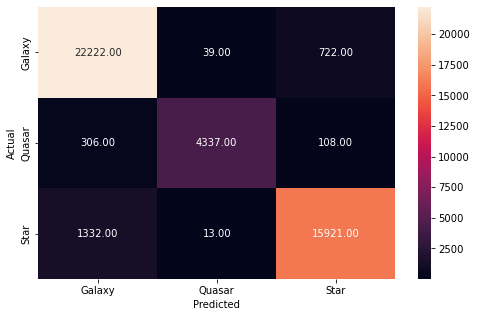

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.fit_transform(X_test)
pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.fit_transform(X_test_std)
knn_model= KNeighborsClassifier()
knn_model.fit(X_train_pca,y_train)
knn_train_predictions = knn_model.predict(X_train_pca)
metrics_score(y_train,knn_train_predictions)

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      2554
           1       0.93      0.86      0.89       528
           2       0.82      0.82      0.82      1918

    accuracy                           0.85      5000
   macro avg       0.87      0.85      0.86      5000
weighted avg       0.85      0.85      0.85      5000



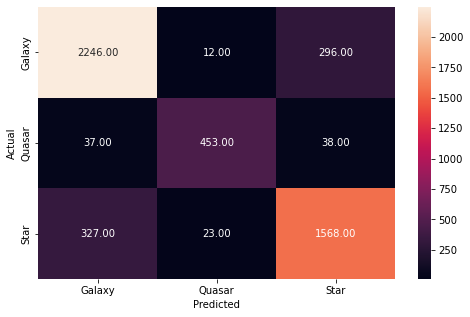

In [12]:
y_test_pred_knn = knn_model.predict(X_test_pca);
metrics_score(y_test, y_test_pred_knn)

**Observations:**

While the performance of the k-Nearest Neighbors algorithm on the test dataset was quite good, it doesn't achieve the 90%+ accuracies and F1-scores we expect from a high-performing Machine Learning model on this dataset, and there is clear scope for improvement there.

In addition, k-Nearest Neighbors also does not computationally scale well with a large amount of data, and can be infeasible to run on big datasets. For these reasons, we need a more efficient and elegant algorithm that is capable of non-linear classification, and we can turn to **Decision Trees** for that.

### **Tree-Based Models**
### **The Decision Tree Classifier**
### **Before Scaling**

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22983
           1       1.00      1.00      1.00      4751
           2       1.00      1.00      1.00     17266

    accuracy                           1.00     45000
   macro avg       1.00      1.00      1.00     45000
weighted avg       1.00      1.00      1.00     45000



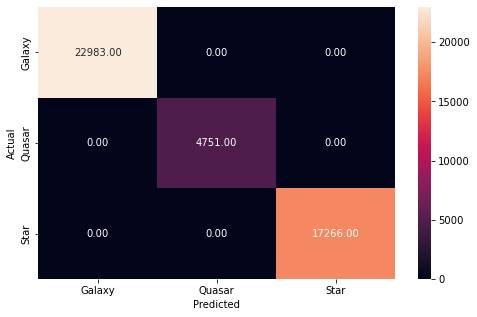

In [13]:
dt = DecisionTreeClassifier(random_state=1);
dt.fit(X_train, y_train)
y_train_pred_dt = dt.predict(X_train)
metrics_score(y_train, y_train_pred_dt)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2554
           1       0.94      0.94      0.94       528
           2       1.00      1.00      1.00      1918

    accuracy                           0.99      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.99      0.99      0.99      5000



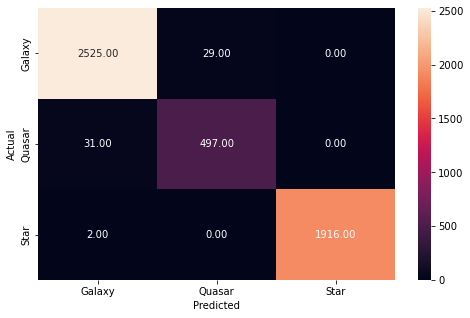

In [14]:
y_test_pred_dt = dt.predict(X_test);
metrics_score(y_test, y_test_pred_dt)

### **Model Evaluation using K-Fold Cross Validation**

In [15]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(dt, X_test, y_test, cv=5)
print(f"The average score of the model with K-5 Cross validation is {np.average(scores)} ")

The average score of the model with K-5 Cross validation is 0.983 


### **After Scaling**

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22983
           1       1.00      1.00      1.00      4751
           2       1.00      1.00      1.00     17266

    accuracy                           1.00     45000
   macro avg       1.00      1.00      1.00     45000
weighted avg       1.00      1.00      1.00     45000



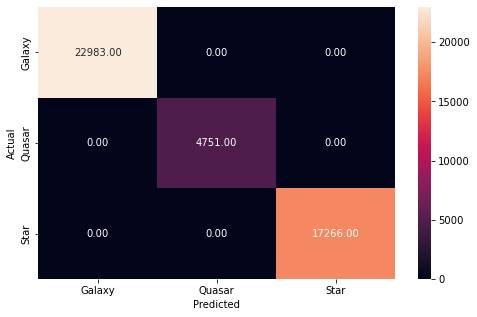

In [16]:
dt = DecisionTreeClassifier(random_state=1);
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.fit_transform(X_test)
dt.fit(X_train_std, y_train)
y_train_pred_dt = dt.predict(X_train_std)
metrics_score(y_train, y_train_pred_dt)

              precision    recall  f1-score   support

           0       0.89      0.98      0.93      2554
           1       0.95      0.93      0.94       528
           2       0.99      0.85      0.92      1918

    accuracy                           0.93      5000
   macro avg       0.94      0.92      0.93      5000
weighted avg       0.93      0.93      0.93      5000



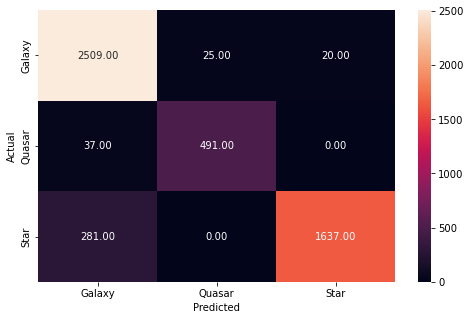

In [17]:
y_test_pred_dt = dt.predict(X_test_std);
metrics_score(y_test, y_test_pred_dt)

As expected, **scaling doesn't make much of a difference in the performance of the Decision Tree model**, since it is not a distance-based algorithm and rather tries to separate instances with orthogonal splits in vector space.

### **Model Evaluation using K-Fold Cross Validation**

In [18]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(dt, X_test_std, y_test, cv=5)
print(f"The average score of the model with K-5 Cross validation is {np.average(scores)} ")

The average score of the model with K-5 Cross validation is 0.983 


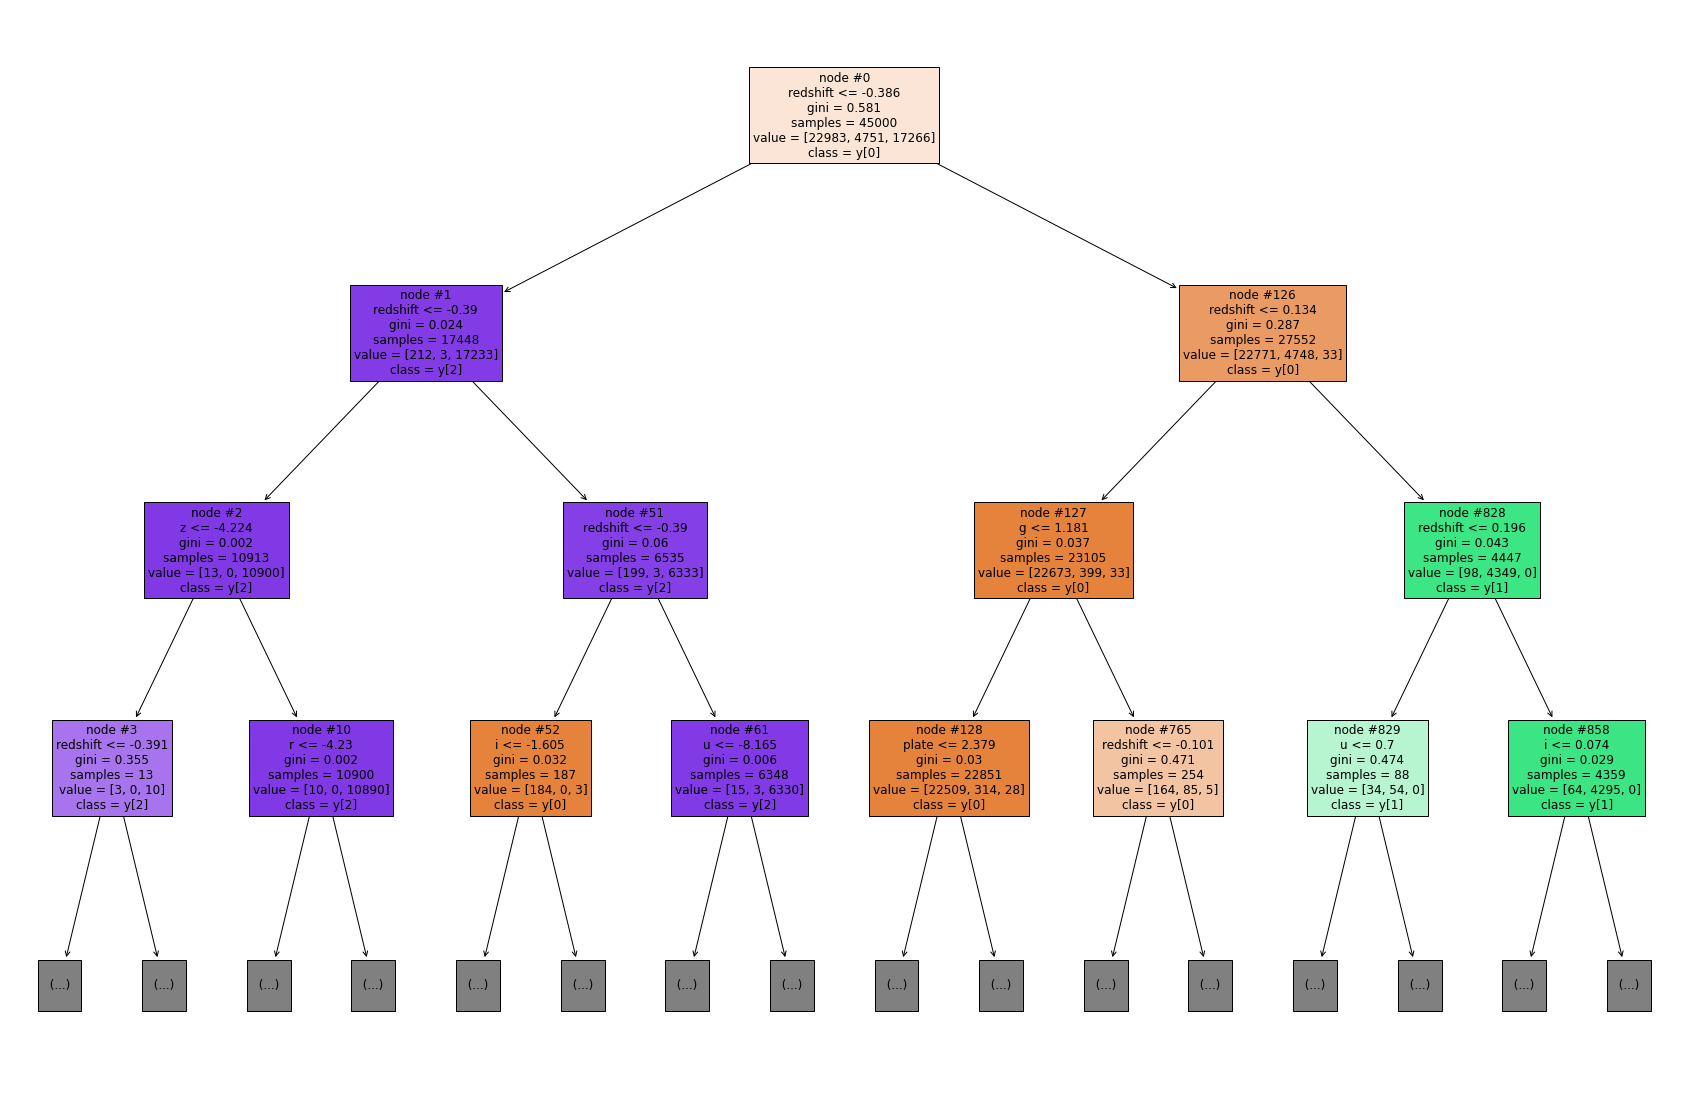

In [19]:
features = list(X.columns);
plt.figure(figsize=(30,20))
tree.plot_tree(dt, max_depth=3, feature_names=features, filled=True, fontsize=12, node_ids=True, class_names=True);
plt.show()

**Observation:**

- **The first split in the decision tree is at the redshift feature**, which implies that it is clearly the most important factor in deciding the class of the celestial object.
- While this may be common knowledge in astronomy, the fact that our model is able to provide this domain-specific knowledge purely from the data, without us having any background in the field, is a hint towards the value of Machine Learning and Data Science.

### **Feature importance**
**Let's look at the feature importance** of the decision tree model

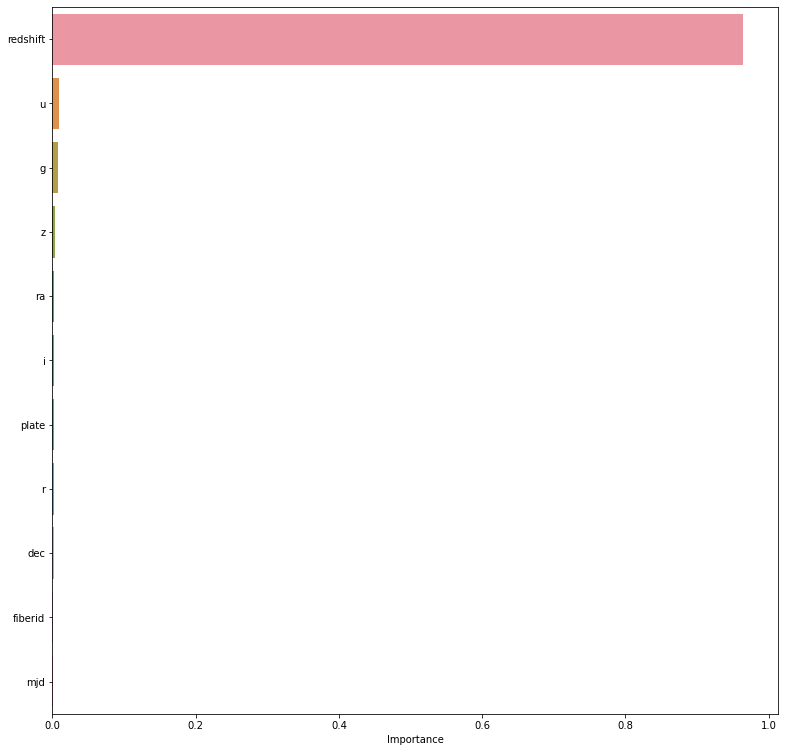

          Importance
redshift     0.96480
u            0.00905
g            0.00838
z            0.00378
ra           0.00285
i            0.00265
plate        0.00249
r            0.00208
dec          0.00183
fiberid      0.00120
mjd          0.00089


In [20]:
# Plotting the feature importance
importances = dt.feature_importances_
columns = X.columns;
importance_df_astro = pd.DataFrame(importances, index=columns, columns=['Importance']).sort_values(by='Importance', ascending=False);
plt.figure(figsize=(13,13));
sns.barplot(importance_df_astro.Importance, importance_df_astro.index)
plt.show()

print(importance_df_astro)

- The **Redshift** is an important variable with a high significance when compared to other variables.


## **Conclusions and Recommendations**
#### **Algorithmic Insights**

- It is apparent from the efforts above that **there are some advantages with Decision Trees** when it comes to non-linear modeling and classification, to obtain a mapping from input to output. 
- Decision Trees are simple to understand and explain, and **they mirror the human pattern of if-then-else decision making.** They are also more computationally efficient than kNN.
- These advantages are what enable them to outperform the k-Nearest Neighbors algorithm, which is also known to be a popular non-linear modeling technique.

#### **Dataset Insights**
- From a dataset perspective, the fact that the **redshift** variable is clearly the most important feature in determining the class of a celestial object, makes it **tailor-made for a Decision Tree's hierarchical nature of decision-making**. As we see in the case study, the Decision Tree prioritizes that feature as the root node of decision splits before moving on to other features.
- Another potential reason for the improved performance of the Decision Tree on this dataset may have to do with the nature of the observations. In astronomical observations such as these, the value ranges of the features of naturally occurring objects such as stars, galaxies, and quasars should, for the most part, lie within certain limits outside of a few exceptions. Those exceptions would be difficult to detect purely through the values of the neighbors of that datapoint in vector space, and would rather need to be detected through fine orthogonal decision boundaries. This nuanced point could be the reason why Decision Trees perform relatively better on this dataset.
- Although there are more advanced ML techniques that use an ensemble of Decision Trees, such as Random Forests and Boosting methods, they are computationally more expensive, and **the 90%+ performance of Decision Trees means they would be our first recommendation to an astronomy team** looking to use this Machine Learning model purely as a second opinion to make quick decisions on Celestial Object Detection.